In [32]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
#from matplotlib.ticker import LinearLocator, FormatStrFormatter,
import matplotlib.ticker as ticker


from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier

import seaborn as sns
import autograd.numpy as np
from autograd import grad, elementwise_grad
import pandas as pd
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.utils import resample
from sklearn.model_selection import KFold, cross_val_score
from sklearn.datasets import load_breast_cancer
plt.rcParams['font.size'] = 14


In [9]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)

    return term1 + term2 + term3 + term4 

# Creating the design matrix, from lecture notes
def create_X(x, y):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = 2 # Number of elements in beta
    X = np.ones((N,l))
    X[:,0] = x
    X[:,1] = y
    return X


# Defining the Mean square error, from lecture notes
def CostFunction(y,ytilde):
    n = len(y)
    return 1/n * np.sum(np.abs(y-ytilde)**2)

def CostFunctionClassification(ao,target):
    n= len(ao)
    return -1/n*np.sum(target*np.log(ao) + (1-target)*np.log(1-ao))
    
def DerCostFunctionClassification(ao,target):
    n= len(ao)
    return -1/n* (target/np.abs(ao) -(1-target)/np.abs(1-ao) )

def MSE(y,ytilde):
    n = len(y)
    return 1/n * np.sum(np.abs(y-ytilde)**2)

# Defining the R2 function, from lecture notes
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def DerivariveCostFunc(y,ytilde):
    n = len(y)
    return 2/n*(y-ytilde)

def Sigmoid(y):
    return np.exp(y)/(1+np.exp(y))

def RELU(y):
    return np.maximum(0,y)

def lexyRelu(y):
    return np.maximum(0.01*y,y)

def Identity(y):
    return y

def Accuracy(ao,target):
    n = len(target)
    ao = np.rint(ao)
    target = np.rint(target)
    s =0
    for i in range(n):
        if ao[i]==target[i]:
            s +=1
    return s/n

#### From lecture notes
def Set_weights_and_bias(n_in,n_hidden,n_out):
#### Setting hiden weights
    W_hidden = 0.1*np.random.randn(n_in, n_hidden)
    b_hidden = np.zeros(n_hidden) +0.01
#### setting output weights
    W_out = 0.1*np.random.randn(n_hidden, n_out)
    b_out = np.zeros(n_out) +0.01
    return W_hidden, W_out, b_hidden, b_out

#### From lecture notes
def feed_forward_train(X,W_hidden, W_out, b_hidden, b_out,activation_function, output_function):
#### Hidden attac
    z_h = X@W_hidden + b_hidden
    a_h = activation_function(z_h)
#### output attac
    z_o = a_h@W_out + b_out
    a_o = output_function(z_o)
    return a_h, a_o, z_h,z_o

#### from lecture notes
def back_prop(X,Target,W_hidden, W_out, b_hidden, b_out,activation_function, output_function,hyper_par,cost_func):
    a_h, a_o,z_h,z_o = feed_forward_train(X,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)
#### output error
    #print(z_o.shape)
    error_out = elementwise_grad(cost_func,0)(a_o,Target)*elementwise_grad(output_function,0)(z_o) #* derivative of output_function
### hidden error
    error_hiden = (error_out @ W_out.T)* elementwise_grad(activation_function,0)(z_h) #*  a_h * (1 - a_h) # the last two terms are the derivative of the sigmoid
##### the last term is the term due to the hyperparameter
    w_out_grad = a_h.T @ error_out + 2*hyper_par*W_out
    b_out_grad = np.sum(error_out, axis=0)
    
    w_hidden_grad = X.T @error_hiden+ 2*hyper_par*W_hidden
    b_hidden_grad = np.sum(error_hiden,axis=0)
    
    return w_out_grad,w_hidden_grad, b_out_grad, b_hidden_grad

###### Main Regression #######
"""
npoints =20
x = np.sort(np.random.uniform(0, 1, npoints)) 
y = np.sort(np.random.uniform(0, 1, npoints)) 
x, y = np.meshgrid(x,y)
X = create_X(x, y)

Y = FrankeFunction(x, y) 

X_train, X_test, y_train, y_test = train_test_split(X, Y.reshape(-1,1), test_size=0.2)

numberMinibach = np.array([4,8,16,32,64])
numEpochs = np.array([10,100,1000])
#epoch_index, minibach_index = 0,3 
etas = np.logspace(-3,-1,3)
lambdas = np.logspace(-4,0,5)
numberOfStraps = 100
hyper_par = np.logspace(-6,-1,6) 
#hyper = 0

epochs = 100 #numEpochs[1]
Minibach = numberMinibach[1] 
#n_hiden = np.array([1,2,4,8,16])
hiden = 8

MSE_test_ler = np.zeros((len(etas),len(hyper_par)))
MSE_train_ler = np.zeros((len(etas),len(hyper_par)))
R2_test_ler = np.zeros((len(etas),len(hyper_par)))
R2_train_ler = np.zeros((len(etas),len(hyper_par)))
counter_eta, counter_hidden =0,0
for hyper in hyper_par:
    for eta in etas:
        MSEdeglisttest = np.zeros(numberOfStraps)
        MSEdeglisttrain = np.zeros(numberOfStraps)
        R2deglisttest = np.zeros(numberOfStraps)
        R2deglisttrain = np.zeros(numberOfStraps)
        for i in range(numberOfStraps):
            w_h,w_o,b_h,b_o =Set_weights_and_bias(2,hiden,1)
            bootX,booty = resample(X_train,y_train.reshape(-1,1))
            MiniBachSize = int(bootX.shape[0]/Minibach)
            for e in range(epochs):
                for j in range(Minibach):
                    miniBach = np.random.randint(Minibach)
                    miniBachMin, miniBachMax = MiniBachSize * miniBach,(MiniBachSize) * (miniBach+1)
                    #a_h,a_o = feed_forward_train(bootX[miniBachMin: miniBachMax],w_h,w_o,b_h,b_o,Sigmoid,Identity)
                    w_out_grad,w_hidden_grad,b_out_grad, b_hidden_grad = back_prop(
                        bootX[miniBachMin: miniBachMax],booty[miniBachMin: miniBachMax],w_h, w_o, b_h, b_o,lexyRelu, Identity,hyper,CostFunction)
                    w_h -= eta*w_hidden_grad
                    w_o -= eta*w_out_grad
                    b_h -= eta*b_hidden_grad
                    b_o -= eta*b_out_grad
            a_h, y_pred_test,z_h,z_o =feed_forward_train(X_test,w_h,w_o,b_h,b_o,lexyRelu,Identity)
            a_h, y_pred_train,z_h,z_o =feed_forward_train(X_train,w_h,w_o,b_h,b_o,lexyRelu,Identity)
            MSEdeglisttest[i] =MSE(y_test,y_pred_test)
            MSEdeglisttrain[i]= MSE(y_train,y_pred_train)
            R2deglisttest[i] = R2(y_test,y_pred_test)
            R2deglisttrain[i] = R2(y_train,y_pred_train)
        MSE_train_ler[counter_eta,counter_hidden] = np.mean(MSEdeglisttrain)
        MSE_test_ler[counter_eta,counter_hidden] = np.mean(MSEdeglisttest)
        R2_test_ler[counter_eta,counter_hidden] = np.mean(R2deglisttest)
        R2_train_ler[counter_eta,counter_hidden] = np.mean(R2deglisttrain)
        counter_eta +=1
        print(counter_eta)
    counter_hidden +=1
    counter_eta =0

tick = ticker.ScalarFormatter(useOffset=False, useMathText=True)
tick.set_powerlimits((0,0))

tx = [u"${}$".format(tick.format_data(x)) for x in hyper_par]
ty = [u"${}$".format(tick.format_data(x)) for x in etas]

#lambdas_sea = [lambdas[i] for i in range(len(lambdas))]
#etas_sea =  [etas[i] for i in range(len(etas))]

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(data=MSE_test_ler,ax=ax, cmap="viridis",annot=True ,xticklabels=tx, yticklabels=ty,)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$\eta$')
plt.tight_layout()
plt.savefig(f"Test_MSE_Single_hidden_function_of_hyper_RELU.pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(data=R2_test_ler,ax=ax, cmap="viridis",annot=True ,xticklabels=tx, yticklabels=ty,)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$\eta$')
plt.tight_layout()
plt.savefig(f"Test_R2_Single_hidden_function_of_hyper_RELU.pdf")
plt.show()


fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(data=MSE_train_ler,ax=ax, cmap="viridis",annot=True ,xticklabels=tx, yticklabels=ty,)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$\eta$')
plt.tight_layout()
plt.savefig(f"Train_MSE_Single_hidden_function_of_hyper_RELU.pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(data=R2_train_ler,ax=ax, cmap="viridis",annot=True ,xticklabels=tx, yticklabels=ty,)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$\eta$')
plt.tight_layout()
plt.savefig(f"Train_R2_Single_hidden_function_of_hyper_RELU.pdf")
plt.show()
"""

'\nnpoints =20\nx = np.sort(np.random.uniform(0, 1, npoints)) \ny = np.sort(np.random.uniform(0, 1, npoints)) \nx, y = np.meshgrid(x,y)\nX = create_X(x, y)\n\nY = FrankeFunction(x, y) \n\nX_train, X_test, y_train, y_test = train_test_split(X, Y.reshape(-1,1), test_size=0.2)\n\nnumberMinibach = np.array([4,8,16,32,64])\nnumEpochs = np.array([10,100,1000])\n#epoch_index, minibach_index = 0,3 \netas = np.logspace(-3,-1,3)\nlambdas = np.logspace(-4,0,5)\nnumberOfStraps = 100\nhyper_par = np.logspace(-6,-1,6) \n#hyper = 0\n\nepochs = 100 #numEpochs[1]\nMinibach = numberMinibach[1] \n#n_hiden = np.array([1,2,4,8,16])\nhiden = 8\n\nMSE_test_ler = np.zeros((len(etas),len(hyper_par)))\nMSE_train_ler = np.zeros((len(etas),len(hyper_par)))\nR2_test_ler = np.zeros((len(etas),len(hyper_par)))\nR2_train_ler = np.zeros((len(etas),len(hyper_par)))\ncounter_eta, counter_hidden =0,0\nfor hyper in hyper_par:\n    for eta in etas:\n        MSEdeglisttest = np.zeros(numberOfStraps)\n        MSEdeglisttrain

Hidden: 1e-06
eta: 1e-06
eta: 1e-05
eta: 0.0001
eta: 0.001
eta: 0.01
eta: 0.1


C:\ProgramData\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:78: RuntimeWarning: invalid value encountered in true_divide
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)


Hidden: 1e-05
eta: 1e-06
eta: 1e-05
eta: 0.0001
eta: 0.001
eta: 0.01
eta: 0.1
Hidden: 0.0001
eta: 1e-06
eta: 1e-05
eta: 0.0001
eta: 0.001
eta: 0.01
eta: 0.1
Hidden: 0.001
eta: 1e-06
eta: 1e-05
eta: 0.0001
eta: 0.001
eta: 0.01
eta: 0.1
Hidden: 0.01
eta: 1e-06
eta: 1e-05
eta: 0.0001
eta: 0.001
eta: 0.01
eta: 0.1
Hidden: 0.1
eta: 1e-06
eta: 1e-05
eta: 0.0001
eta: 0.001
eta: 0.01
eta: 0.1


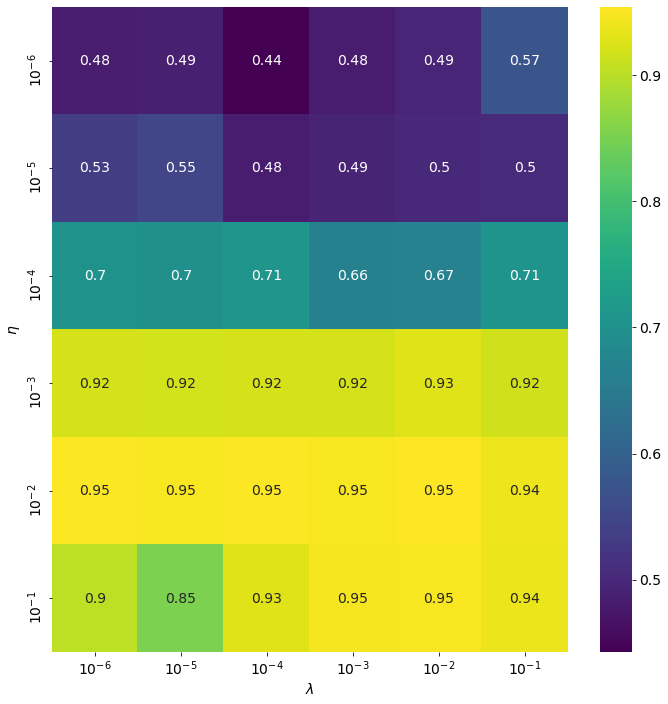

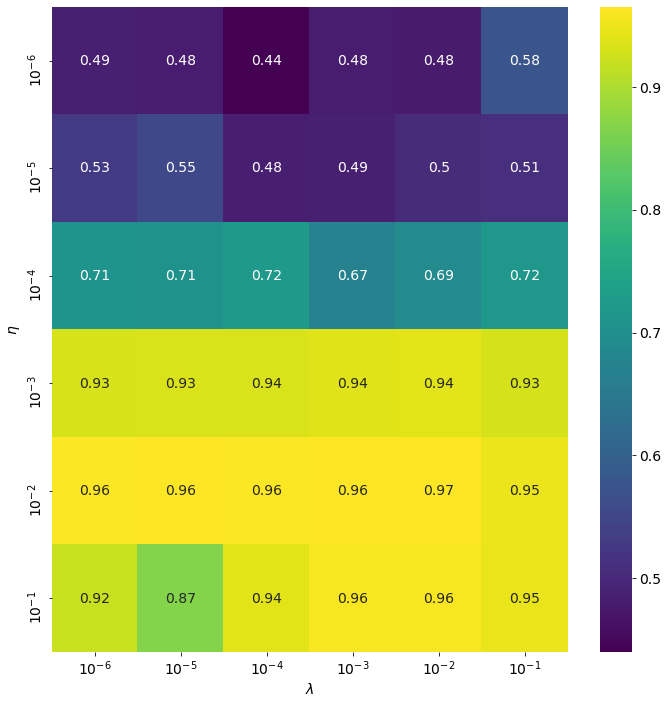

In [56]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target.reshape(-1,1),random_state=1)
scaler =StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


numberMinibach = np.array([4,8,16,32,64])
numEpochs = np.array([10,100,1000])
#epoch_index, minibach_index = 0,3 
etas = np.logspace(-3,-1,3)
lambdas = np.logspace(-4,0,5)
numberOfStraps = 100
hyper_par = np.logspace(-6,-1,6) 
#hyper = 0

epochs = 100 #numEpochs[1]
Minibach = numberMinibach[1] 
#n_hiden = np.array([1,2,4,8,16])
#hiden = 8
#MiniBachSize = 8
MiniBachSice = int(X_train.shape[0]/Minibach)
hyper =0# 0.001
etas = np.logspace(-6,-1,6)
hyper_par = np.logspace(-6,-1,6)
#n_hidden = np.array([1,2,4,8,16,32,64,128])
#eta =0.01
hidden = 16

numberOfStraps = 50


activation = Identity
out_func = Sigmoid

Accuracy_test_ler = np.zeros((len(etas),len(hyper_par)))
Accuracy_train_ler = np.zeros((len(etas),len(hyper_par)))

counter_eta,counter_hidden = 0,0
for hyper in hyper_par:
    print('Hidden:',hyper)
    for eta in etas:
        print('eta:',eta)
        Accuracydeglisttest = np.zeros(numberOfStraps)
        Accuracydeglisttrain = np.zeros(numberOfStraps)
        for i in range(numberOfStraps):
            w_h,w_o,b_h,b_o =Set_weights_and_bias(30,hidden,1)
            bootX,booty = resample(X_train,y_train)
            for e in range(epochs):
                for j in range(Minibach):
                    miniBach = np.random.randint(Minibach)
                    miniBachMin, miniBachMax = MiniBachSize * miniBach,(MiniBachSize) * (miniBach+1)
                    #a_h,a_o = feed_forward_train(bootX[miniBachMin: miniBachMax],w_h,w_o,b_h,b_o,Sigmoid,Identity)
                    w_out_grad,w_hidden_grad,b_out_grad, b_hidden_grad = back_prop(
                        bootX[miniBachMin: miniBachMax],booty[miniBachMin: miniBachMax],w_h, w_o, b_h, b_o,activation, out_func,hyper,CostFunctionClassification)
                    w_h -= eta*w_hidden_grad
                    w_o -= eta*w_out_grad
                    b_h -= eta*b_hidden_grad
                    b_o -= eta*b_out_grad
            a_h, y_pred_test,z_h,z_o =feed_forward_train(X_test,w_h,w_o,b_h,b_o,activation,out_func)
            a_h, y_pred_train,z_h,z_o =feed_forward_train(X_train,w_h,w_o,b_h,b_o,activation,out_func)
            Accuracydeglisttrain[i] = Accuracy(y_pred_train,y_train)
            Accuracydeglisttest[i] = Accuracy(y_pred_test,y_test)
        Accuracy_train_ler[counter_eta,counter_hidden] = np.mean(Accuracydeglisttrain)
        Accuracy_test_ler[counter_eta,counter_hidden] = np.mean(Accuracydeglisttest)
        counter_eta +=1
    counter_hidden +=1
    counter_eta = 0


tick = ticker.ScalarFormatter(useOffset=False, useMathText=True)
tick.set_powerlimits((0,0))

tx = [u"${}$".format(tick.format_data(x)) for x in hyper_par]
ty = [u"${}$".format(tick.format_data(x)) for x in etas]

#lambdas_sea = [lambdas[i] for i in range(len(lambdas))]
#etas_sea =  [etas[i] for i in range(len(etas))]

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(data=Accuracy_test_ler,ax=ax, cmap="viridis",annot=True ,xticklabels=tx, yticklabels=ty,)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$\eta$')
plt.tight_layout()
plt.savefig(f"Test_Accuracy_Single_hidden_function_of_hyper_Identity.pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(data=Accuracy_train_ler,ax=ax, cmap="viridis",annot=True ,xticklabels=tx, yticklabels=ty,)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$\eta$')
plt.tight_layout()
plt.savefig(f"Train_Accuracy_Single_hidden_function_of_hyper_Identity.pdf")
plt.show()


In [55]:
####### Test of scikit-learn, to make sure that our results ar not totaly wrong ######
### Get more or less the same when using sgd. If we use adam or lbfgs then that is bether than our code. 
### This is much faster than ours, but that is not suprising

clf =  MLPClassifier(solver='sgd', alpha=0.01,hidden_layer_sizes=(16), random_state=20)

clf.fit(X_train,y_train)

pred = clf.predict(X_test)

print(Accuracy(pred,y_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.951048951048951


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
